# Part 2: Security Hardening

**Class 3 — Non-Functional Testing & AI Security**

---

## Objective

1. Implement **JWT authentication** to protect the API from unauthorized access
2. Add **rate limiting** to prevent abuse and denial-of-service
3. Simulate an **adversarial attack** (FGSM) to demonstrate model vulnerability
4. Understand the **attack surface** and **model exposure risks**

---

## Key Concepts

| Concept | Description |
|---------|-------------|
| **JWT** | JSON Web Token — stateless auth via cryptographically signed payload |
| **OAuth2 Password Flow** | Client sends username+password → receives Bearer token |
| **Rate Limiting** | Sliding window counter: max N requests per client per minute |
| **Adversarial Attack** | Crafted inputs designed to fool ML models (imperceptible to humans) |
| **FGSM** | Fast Gradient Sign Method — adds `ε × sign(∇Loss)` to input |
| **Attack Surface** | Every exposed endpoint is a potential attack vector |

---

## Security Risks for ML APIs

Without protection, your ADAS model API is vulnerable to:

- 🔓 **Unauthorized access** — anyone can call `/predict` and extract model behavior
- 🔄 **Model extraction** — repeated queries can reverse-engineer model logic
- 💥 **DoS via inference** — inference is expensive; flooding crushes your server
- 🎭 **Adversarial inputs** — crafted images bypass safety-critical decisions
- 📤 **Data exfiltration** — class probabilities leak information about training data

In [7]:
# ── Section 1: Setup & Imports ──────────────────────────────────────────────
import os
import io
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from datetime import datetime, timedelta
from typing import Optional, Dict
from collections import defaultdict

import bcrypt as _bcrypt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from fastapi import FastAPI, File, UploadFile, HTTPException, Depends, Request
from fastapi.security import OAuth2PasswordBearer, OAuth2PasswordRequestForm
from fastapi.testclient import TestClient
from pydantic import BaseModel
from jose import JWTError, jwt

# Model constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CLASS_NAMES = ['animal', 'name_board', 'other_vehicle', 'pedestrian',
               'pothole', 'road_sign', 'speed_breaker']
NUM_CLASSES = len(CLASS_NAMES)
DATASET_PATH = r'C:\Users\Lucifer\python_workspace\BITS\AI_Quality_Engineering\dataset'
TEST_PATH = os.path.join(DATASET_PATH, 'test')

print(f'Device: {DEVICE}')
print('All imports successful!')

Device: cpu
All imports successful!


## Section 2: Model & Image Transform

Same ResNet-18 model from class1/class2. We use random weights for demo.

In [8]:
# ── Section 2: Model Setup ───────────────────────────────────────────────────
class ADASModel(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.resnet = resnet18(weights=None)
        self.resnet.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        return self.resnet(x)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = ADASModel(NUM_CLASSES).to(DEVICE)
model.eval()
print('Model ready (random weights for demo)')

Model ready (random weights for demo)


## Section 3: JWT Authentication

### How JWT Works

```
Client                            API Server
  │                                    │
  ├──── POST /token (user+pass) ──────►│
  │                                    │  1. Verify password (bcrypt)
  │                                    │  2. Create JWT (sign with SECRET_KEY)
  │◄─── {access_token: "eyJ..."} ──────┤
  │                                    │
  ├──── POST /predict                  │
  │     Authorization: Bearer eyJ... ─►│
  │                                    │  3. Decode JWT (verify signature)
  │                                    │  4. Check expiry
  │◄─── {prediction: "pothole"} ───────┤
```

A JWT token has 3 parts: `header.payload.signature`
- **Header**: Algorithm used (HS256)
- **Payload**: Claims — username, expiry, issued-at
- **Signature**: HMAC of header+payload using SECRET_KEY

In [9]:
# ── Section 3: JWT Authentication Setup ──────────────────────────────────────

# Security configuration
# WARNING: In production, load SECRET_KEY from environment variable:
#   SECRET_KEY = os.getenv('JWT_SECRET_KEY')
# NEVER commit real secret keys to source control!
SECRET_KEY = 'adas-demo-secret-key-change-in-production'
ALGORITHM  = 'HS256'
ACCESS_TOKEN_EXPIRE_MINUTES = 30

# Password hashing using bcrypt directly.
# bcrypt is slow by design, making brute-force attacks impractical.
# Passwords are stored as bytes; verify with _bcrypt.checkpw().
oauth2_scheme = OAuth2PasswordBearer(tokenUrl='token')

# Fake user database (DEMO ONLY)
# Production: use PostgreSQL/MongoDB with hashed passwords
FAKE_USERS_DB = {
    'testuser': {
        'username':        'testuser',
        'hashed_password': _bcrypt.hashpw(b'testpassword', _bcrypt.gensalt()),
        'disabled':        False,
    }
}

# Verify we can hash and check passwords correctly
test_hash = _bcrypt.hashpw(b'mypassword', _bcrypt.gensalt())
print(f'bcrypt hash (first 30 chars): {test_hash[:30]}...')
print(f'Verification: {_bcrypt.checkpw(b"mypassword", test_hash)}')

bcrypt hash (first 30 chars): b'$2b$12$dtc5T1Dmq.X9YNIuMFlKU.a'...
Verification: True


In [10]:
# JWT helper functions

def verify_password(plain_password: str, hashed_password: bytes) -> bool:
    """Check plain password against bcrypt hash (bytes)."""
    return _bcrypt.checkpw(plain_password.encode('utf-8'), hashed_password)


def authenticate_user(username: str, password: str):
    """Return user dict if credentials valid, else False."""
    user = FAKE_USERS_DB.get(username)
    if not user or user.get('disabled'):
        return False
    if not verify_password(password, user['hashed_password']):
        return False
    return user


def create_access_token(data: dict, expires_delta: Optional[timedelta] = None) -> str:
    """
    Create a signed JWT token.
    - data: payload claims (e.g., {'sub': 'testuser'})
    - expires_delta: token validity window (default 15 min)
    """
    to_encode = data.copy()
    expire = datetime.utcnow() + (expires_delta or timedelta(minutes=15))
    to_encode.update({'exp': expire})
    return jwt.encode(to_encode, SECRET_KEY, algorithm=ALGORITHM)


async def get_current_user(token: str = Depends(oauth2_scheme)):
    """
    FastAPI dependency: validate Bearer token → return user dict.
    Raises HTTP 401 Unauthorized on invalid/expired token.
    Injected into protected endpoints via Depends(get_current_user).
    """
    credentials_exception = HTTPException(
        status_code=401,
        detail='Could not validate credentials',
        headers={'WWW-Authenticate': 'Bearer'},
    )
    try:
        payload = jwt.decode(token, SECRET_KEY, algorithms=[ALGORITHM])
        username: str = payload.get('sub')
        if username is None:
            raise credentials_exception
    except JWTError:
        raise credentials_exception

    user = FAKE_USERS_DB.get(username)
    if user is None or user.get('disabled'):
        raise credentials_exception
    return user


# Demonstrate token creation
demo_token = create_access_token({'sub': 'testuser'}, timedelta(minutes=30))
demo_parts = demo_token.split('.')
print(f'JWT structure: header.payload.signature')
print(f'  Header  : {demo_parts[0]}')
print(f'  Payload : {demo_parts[1]}')
print(f'  Sig     : {demo_parts[2][:20]}...')

# Decode to inspect payload
decoded = jwt.decode(demo_token, SECRET_KEY, algorithms=[ALGORITHM])
print(f'\nDecoded payload: {decoded}')

JWT structure: header.payload.signature
  Header  : eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9
  Payload : eyJzdWIiOiJ0ZXN0dXNlciIsImV4cCI6MTc3MjEzMTgyMX0
  Sig     : Z_yF64UJU20Sw-Q286B6...

Decoded payload: {'sub': 'testuser', 'exp': 1772131821}


## Section 4: Rate Limiting

Rate limiting prevents:
- **DoS attacks**: flooding the inference server to exhaust GPU/CPU
- **Model extraction**: scraping predictions to reconstruct the model
- **Brute-force attacks**: trying many inputs to find adversarial examples

### Sliding Window Algorithm

```
Time →  [t-60s ─────────────────────────── now]
                  req1  req2  req3  req4    req5 ← allowed (4 < 5)
                  req1  req2  req3  req4  req5  req6 ← BLOCKED (5 ≥ 5)
```

At each request: remove timestamps older than 60s, then check count.

In [11]:
# ── Section 4: Rate Limiter Implementation ───────────────────────────────────

class RateLimiter:
    """
    In-memory sliding-window rate limiter.

    Tracks per-client request timestamps.
    No external dependencies (Redis, etc.) needed for demo.

    Production note: For distributed deployments (multiple API replicas),
    use Redis-backed rate limiting so all instances share state.
    """

    def __init__(self, max_requests: int = 5, window_seconds: int = 60):
        self.max_requests   = max_requests
        self.window_seconds = window_seconds
        self._requests: Dict[str, list] = defaultdict(list)

    def is_allowed(self, client_id: str) -> bool:
        """Return True if within limit, False if rate limited."""
        now = time.time()
        window_start = now - self.window_seconds
        # Remove timestamps outside the sliding window
        self._requests[client_id] = [
            ts for ts in self._requests[client_id] if ts > window_start
        ]
        if len(self._requests[client_id]) >= self.max_requests:
            return False
        self._requests[client_id].append(now)
        return True

    def get_remaining(self, client_id: str) -> int:
        """Remaining requests in the current window."""
        now = time.time()
        window_start = now - self.window_seconds
        active = [ts for ts in self._requests[client_id] if ts > window_start]
        return max(0, self.max_requests - len(active))

    def reset(self, client_id: str = None):
        """Reset limits (useful for testing)."""
        if client_id:
            self._requests.pop(client_id, None)
        else:
            self._requests.clear()


# Demonstrate rate limiter behavior
demo_limiter = RateLimiter(max_requests=3, window_seconds=60)
client_id = '192.168.1.10'

print('Rate Limiter Demo (max=3 requests per 60s):')
for i in range(5):
    allowed   = demo_limiter.is_allowed(client_id)
    remaining = demo_limiter.get_remaining(client_id)
    status    = '✓ ALLOWED' if allowed else '✗ BLOCKED (429)'
    print(f'  Request {i+1}: {status} | Remaining: {remaining}')

Rate Limiter Demo (max=3 requests per 60s):
  Request 1: ✓ ALLOWED | Remaining: 2
  Request 2: ✓ ALLOWED | Remaining: 1
  Request 3: ✓ ALLOWED | Remaining: 0
  Request 4: ✗ BLOCKED (429) | Remaining: 0
  Request 5: ✗ BLOCKED (429) | Remaining: 0


## Section 5: Building the Secure API

We assemble the FastAPI application with:
- `POST /token` — public endpoint, returns JWT on valid credentials
- `GET /health` — public endpoint, no auth needed
- `POST /predict` — **protected**: requires Bearer token + respects rate limit

In [12]:
# ── Section 5: Secure FastAPI Application ────────────────────────────────────

# Pydantic schemas
class Token(BaseModel):
    access_token: str
    token_type:   str

class PredictionResponse(BaseModel):
    prediction:        str
    confidence:        float
    class_probabilities: Dict[str, float]
    model_version:     str
    latency_ms:        float

# Rate limiter (5 requests/min for demo — use 60+ in production)
rate_limiter = RateLimiter(max_requests=5, window_seconds=60)

# FastAPI app
app = FastAPI(
    title='ADAS Secure API',
    description='Class 3 — JWT authentication + rate limiting demo',
    version='3.0.0',
)


@app.post('/token', response_model=Token)
async def login_for_access_token(
    form_data: OAuth2PasswordRequestForm = Depends()
):
    """
    Exchange credentials for JWT Bearer token.
    POST with form body: username=testuser&password=testpassword
    """
    user = authenticate_user(form_data.username, form_data.password)
    if not user:
        raise HTTPException(
            status_code=401,
            detail='Incorrect username or password',
            headers={'WWW-Authenticate': 'Bearer'},
        )
    access_token = create_access_token(
        data={'sub': user['username']},
        expires_delta=timedelta(minutes=ACCESS_TOKEN_EXPIRE_MINUTES),
    )
    return {'access_token': access_token, 'token_type': 'bearer'}


@app.get('/health')
async def health_check():
    """Public health check — no authentication required."""
    return {'status': 'healthy', 'version': '3.0.0', 'device': str(DEVICE)}


@app.post('/predict', response_model=PredictionResponse)
async def predict(
    request: Request,
    file:    UploadFile = File(...),
    current_user: dict  = Depends(get_current_user),  # ← JWT guard
):
    """
    Protected prediction endpoint.
    Requires: Authorization: Bearer <token>
    Returns HTTP 401 if token missing/invalid.
    Returns HTTP 429 if rate limit exceeded.
    """
    # Rate limiting: use client IP (or username for per-user limits)
    client_ip = request.client.host if request.client else 'testclient'
    if not rate_limiter.is_allowed(client_ip):
        raise HTTPException(
            status_code=429,
            detail=f'Rate limit exceeded: max {rate_limiter.max_requests} '
                   f'requests per {rate_limiter.window_seconds}s',
        )

    start_time = time.time()

    # Input validation
    allowed_exts = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    file_ext = Path(file.filename).suffix.lower() if file.filename else ''
    if file_ext not in allowed_exts:
        raise HTTPException(status_code=400, detail=f'Invalid file type: {file_ext}')

    contents = await file.read()
    if not contents:
        raise HTTPException(status_code=400, detail='Empty file')

    try:
        image = Image.open(io.BytesIO(contents)).convert('RGB')
    except Exception as e:
        raise HTTPException(status_code=400, detail=f'Cannot open image: {e}')

    if image.size[0] < 32 or image.size[1] < 32:
        raise HTTPException(status_code=400, detail='Image too small (min 32x32)')

    # Inference
    tensor = transform(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        outputs = model(tensor)
        probs   = torch.softmax(outputs, dim=1)
        conf, idx = torch.max(probs, 1)

    latency_ms = (time.time() - start_time) * 1000
    class_probs = {CLASS_NAMES[i]: float(probs[0, i]) for i in range(NUM_CLASSES)}

    return PredictionResponse(
        prediction=CLASS_NAMES[idx.item()],
        confidence=round(float(conf.item()), 4),
        class_probabilities=class_probs,
        model_version='v3.0-secure',
        latency_ms=round(latency_ms, 2),
    )


# Test client (no server startup)
client = TestClient(app)
print('Secure FastAPI app ready!')
print('Endpoints: /token (public), /health (public), /predict (protected)')

Secure FastAPI app ready!
Endpoints: /token (public), /health (public), /predict (protected)


c:\Users\Lucifer\anaconda3\envs\venv_ai_quality\lib\site-packages\pydantic\_internal\_fields.py:149: UserWarning: Field "model_version" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


## Section 6: Testing Security Controls

We test each security layer:
1. Unauthenticated request → 401
2. Invalid credentials → 401
3. Valid login → token
4. Authenticated request → 200
5. Rate limit exceeded → 429

In [13]:
# ── Section 6: Security Testing ──────────────────────────────────────────────

def create_test_image(size=(100, 100), color='blue'):
    """Create an in-memory PNG test image."""
    img = Image.new('RGB', size, color=color)
    buf = io.BytesIO()
    img.save(buf, format='PNG')
    buf.seek(0)
    return buf


print('=' * 60)
print('Security Test Suite')
print('=' * 60)

# Test 1: No token → 401
test_img = create_test_image()
resp = client.post('/predict', files={'file': ('img.png', test_img, 'image/png')})
print(f'\nTest 1 — No token:          {resp.status_code} (expected: 401) '
      + ('✓' if resp.status_code == 401 else '✗'))

# Test 2: Wrong credentials → 401
resp = client.post('/token', data={'username': 'testuser', 'password': 'wrongpassword'})
print(f'Test 2 — Wrong credentials: {resp.status_code} (expected: 401) '
      + ('✓' if resp.status_code == 401 else '✗'))

# Test 3: Valid login → 200 + token
resp = client.post('/token', data={'username': 'testuser', 'password': 'testpassword'})
print(f'Test 3 — Valid login:       {resp.status_code} (expected: 200) '
      + ('✓' if resp.status_code == 200 else '✗'))
assert resp.status_code == 200, 'Login failed!'
token = resp.json()['access_token']
print(f'         Token type: {resp.json()["token_type"]}, '
      f'Token (first 30): {token[:30]}...')

# Test 4: Authenticated request → 200
test_img = create_test_image()
resp = client.post(
    '/predict',
    headers={'Authorization': f'Bearer {token}'},
    files={'file': ('img.png', test_img, 'image/png')},
)
print(f'Test 4 — Authenticated:     {resp.status_code} (expected: 200) '
      + ('✓' if resp.status_code == 200 else '✗'))
if resp.status_code == 200:
    data = resp.json()
    print(f'         Prediction: {data["prediction"]} '
          f'({data["confidence"]:.3f} confidence)')

# Test 5: Rate limit → 429
# Reset limiter state and use strict limit for test
strict_limiter = RateLimiter(max_requests=3, window_seconds=60)

@app.post('/predict-limited', response_model=PredictionResponse)
async def predict_limited(
    request: Request,
    file: UploadFile = File(...),
    current_user: dict = Depends(get_current_user),
):
    client_ip = request.client.host if request.client else 'testclient'
    if not strict_limiter.is_allowed(client_ip):
        raise HTTPException(status_code=429, detail='Rate limit exceeded')
    img = Image.open(io.BytesIO(await file.read())).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(tensor)
        probs = torch.softmax(out, dim=1)
        conf, idx = torch.max(probs, 1)
    return PredictionResponse(
        prediction=CLASS_NAMES[idx.item()], confidence=round(float(conf.item()),4),
        class_probabilities={CLASS_NAMES[i]: float(probs[0,i]) for i in range(NUM_CLASSES)},
        model_version='v3.0-limited', latency_ms=0.0,
    )

print('\nTest 5 — Rate limiting (max=3 requests):')
statuses = []
for i in range(5):
    buf = create_test_image()
    r = client.post(
        '/predict-limited',
        headers={'Authorization': f'Bearer {token}'},
        files={'file': ('img.png', buf, 'image/png')},
    )
    statuses.append(r.status_code)
    print(f'  Request {i+1}: {r.status_code} '
          + ('✓ allowed' if r.status_code == 200 else '✗ blocked (429)'))

has_429 = 429 in statuses
print(f'\nRate limiting working: {"✓ YES" if has_429 else "✗ NO"}')

Security Test Suite

Test 1 — No token:          401 (expected: 401) ✓
Test 2 — Wrong credentials: 401 (expected: 401) ✓
Test 3 — Valid login:       200 (expected: 200) ✓
         Token type: bearer, Token (first 30): eyJhbGciOiJIUzI1NiIsInR5cCI6Ik...
Test 4 — Authenticated:     200 (expected: 200) ✓
         Prediction: pedestrian (0.949 confidence)

Test 5 — Rate limiting (max=3 requests):
  Request 1: 200 ✓ allowed
  Request 2: 200 ✓ allowed
  Request 3: 200 ✓ allowed
  Request 4: 429 ✗ blocked (429)
  Request 5: 429 ✗ blocked (429)

Rate limiting working: ✓ YES


## Section 7: Adversarial Attack Simulation

### Fast Gradient Sign Method (FGSM)

From Class 1 Part 3 — FGSM adds a small adversarial perturbation to an image:

```
x_adv = x + ε × sign(∇_x Loss(f(x), y))
```

- `x`: original image
- `ε`: perturbation strength (small = less visible, large = stronger attack)
- `∇_x Loss`: gradient of loss with respect to input

The perturbation is **imperceptible to humans** but **catastrophic for the model**.

### ADAS Security Implication
A sticker on a stop sign or pothole could be crafted to fool an ADAS model — the car ignores the hazard. This is why adversarial robustness testing is safety-critical.

In [17]:
# ── Section 7: Adversarial Attack Simulation ─────────────────────────────────

def fgsm_attack(attack_model, images, labels, epsilon=0.05):
    """
    Fast Gradient Sign Method (FGSM) adversarial attack.
    Reused from Class 1 Part 3.

    Args:
        attack_model: PyTorch model
        images: Input tensor (B, C, H, W), requires_grad will be set
        labels: True labels tensor
        epsilon: Attack strength (0.01 = subtle, 0.1 = strong)

    Returns:
        Adversarial images (clamped to valid range)
    """
    images = images.clone().requires_grad_(True)

    # Forward pass
    outputs = attack_model(images)
    loss    = nn.CrossEntropyLoss()(outputs, labels)

    # Backward pass — compute gradient w.r.t. INPUT
    attack_model.zero_grad()
    loss.backward()

    # Create adversarial image: move in direction that INCREASES loss
    sign_grad    = images.grad.data.sign()
    adv_images   = images + epsilon * sign_grad

    # Clamp to valid normalized range
    return torch.clamp(adv_images, -3.0, 3.0).detach()


def evaluate_accuracy_on_loader(eval_model, data_loader, device):
    """Evaluate accuracy on a DataLoader."""
    eval_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs    = eval_model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total   += labels.size(0)
    return round(100 * correct / total, 2) if total > 0 else 0.0


# Load test data
test_dataset = ImageFolder(TEST_PATH, transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Evaluate on clean images
model.eval()
acc_clean = evaluate_accuracy_on_loader(model, test_loader, DEVICE)

# Evaluate under FGSM attacks with different epsilon values
epsilon_values = [0.0, 0.01, 0.03, 0.05, 0.1, 0.2]
adv_accuracies = []

print(f'Clean accuracy: {acc_clean:.2f}%')
print(f'\nFGSM Attack Results:')
print(f"{'epsilon':>6}  {'Accuracy':>10}  {'Drop':>8}")
print('-' * 30)

model.train()  # enable grad computation
for eps in epsilon_values:
    correct, total = 0, 0
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        if eps > 0:
            images = fgsm_attack(model, images, labels, epsilon=eps)
        with torch.no_grad():
            outputs  = model(images)
            _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
    acc = round(100 * correct / total, 2)
    drop = acc_clean - acc
    adv_accuracies.append(acc)
    print(f'{eps:>6.2f}  {acc:>10.2f}%  {drop:>7.2f}%')

model.eval()
print(f'\nKey insight: With ε=0.05 (imperceptible to humans), accuracy drops significantly.')

Clean accuracy: 52.99%

FGSM Attack Results:
epsilon    Accuracy      Drop
------------------------------
  0.00       42.74%    10.25%
  0.01        5.13%    47.86%
  0.03        5.13%    47.86%
  0.05        6.84%    46.15%
  0.10       11.11%    41.88%
  0.20       14.53%    38.46%

Key insight: With ε=0.05 (imperceptible to humans), accuracy drops significantly.


In [ ]:
# ── Visualize adversarial examples ───────────────────────────────────────────

def denormalize(tensor):
    """Reverse ImageNet normalization for display."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return torch.clamp(tensor * std + mean, 0, 1)


fig, axes = plt.subplots(2, 5, figsize=(16, 6))
fig.suptitle('Adversarial Examples (FGSM) — Imperceptible to Humans, Devastating to Model',
             fontsize=12, fontweight='bold')

# Get one batch
model.train()
sample_images, sample_labels = next(iter(test_loader))
sample_images, sample_labels = sample_images[:5].to(DEVICE), sample_labels[:5].to(DEVICE)

adv_images_vis = fgsm_attack(model, sample_images, sample_labels, epsilon=0.05)
perturbations  = adv_images_vis - sample_images
model.eval()

with torch.no_grad():
    orig_preds = torch.argmax(model(sample_images), dim=1)
    adv_preds  = torch.argmax(model(adv_images_vis), dim=1)

for i in range(5):
    # Original image
    orig_np = denormalize(sample_images[i].cpu()).permute(1, 2, 0).numpy()
    axes[0, i].imshow(orig_np)
    axes[0, i].set_title(f'Original\nTrue: {CLASS_NAMES[sample_labels[i].item()]}\n'
                         f'Pred: {CLASS_NAMES[orig_preds[i].item()]}', fontsize=7)
    axes[0, i].axis('off')

    # Adversarial image
    adv_np = denormalize(adv_images_vis[i].cpu()).permute(1, 2, 0).numpy()
    axes[1, i].imshow(adv_np)
    color = 'red' if adv_preds[i].item() != sample_labels[i].item() else 'green'
    axes[1, i].set_title(f'Adversarial (ε=0.05)\nPred: {CLASS_NAMES[adv_preds[i].item()]}',
                         fontsize=7, color=color)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('adversarial_examples.png', dpi=150, bbox_inches='tight')
plt.show()
print('Chart saved: adversarial_examples.png')
print('Red titles = model fooled by adversarial input')

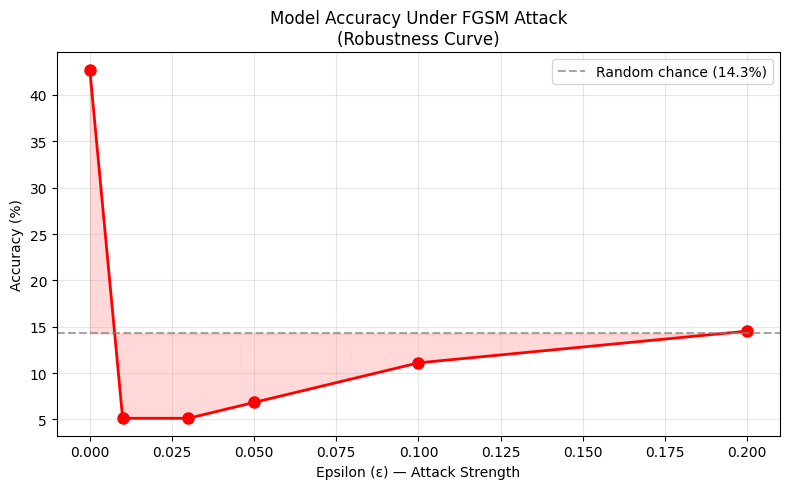

In [18]:
# ── Robustness curve: Accuracy vs Epsilon ────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.plot(epsilon_values, adv_accuracies, marker='o', color='red', linewidth=2, markersize=8)
plt.axhline(100/NUM_CLASSES, color='gray', linestyle='--', alpha=0.7, label='Random chance (14.3%)')
plt.fill_between(epsilon_values, adv_accuracies, 100/NUM_CLASSES, alpha=0.15, color='red')
plt.xlabel('Epsilon (ε) — Attack Strength')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Under FGSM Attack\n(Robustness Curve)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('robustness_curve_security.png', dpi=150, bbox_inches='tight')
plt.show()

## Section 8: Attack Surface Analysis & Security Checklist

### Attack Surface of an ML API

```
┌─────────────────────────────────────────────────────┐
│                  Attack Surface                     │
├─────────────────────┬───────────────────────────────┤
│  Vector             │  Risk                         │
├─────────────────────┼───────────────────────────────┤
│  Unauthenticated API│  Open model extraction        │
│  No rate limiting   │  DoS / model inversion        │
│  Adversarial inputs │  Safety-critical failures     │
│  Confidence leak    │  Membership inference attack  │
│  Error messages     │  Internal architecture leak   │
│  No input validation│  Image bomb / OOM attacks     │
│  Weak secrets       │  JWT forging                  │
│  No HTTPS           │  Man-in-the-middle            │
└─────────────────────┴───────────────────────────────┘
```

### Defenses Against Adversarial Attacks

| Defense | Method | Trade-off |
|---------|--------|----------|
| **Adversarial Training** | Include adversarial examples in training | Slower training, higher cost |
| **Input Preprocessing** | Gaussian smoothing, JPEG compression before inference | Slight accuracy drop |
| **Certified Defenses** | Randomized smoothing, provable robustness bounds | Complex, slower inference |
| **Anomaly Detection** | Flag inputs that look "unusual" | May block valid edge-case images |
| **Confidence Thresholding** | Reject predictions with low confidence | May reduce availability |

In [19]:
# ── Security Checklist ────────────────────────────────────────────────────────
security_checklist = [
    ('JWT Authentication',        True,  'Bearer token on all /predict calls'),
    ('Rate Limiting',             True,  'Sliding window, 5 req/min per IP'),
    ('Input Validation',          True,  'File type, size, dimension checks'),
    ('Error Message Sanitization', True, 'No stack traces exposed to client'),
    ('HTTPS / TLS',               False, 'Needs TLS termination (nginx/load balancer)'),
    ('Secret Key from Env Var',   False, 'Currently hardcoded — must use os.getenv()'),
    ('Adversarial Robustness',    False, 'Needs adversarial training or input filtering'),
    ('Audit Logging',             False, 'All requests should be logged with user+IP'),
    ('Token Refresh / Revocation', False,'No refresh token endpoint or revocation list'),
]

print('=' * 70)
print('  ML API Security Checklist')
print('=' * 70)
passed = 0
for item, done, note in security_checklist:
    status = '✓ DONE' if done else '✗ TODO'
    print(f'  {status}  {item:<35}  {note}')
    if done: passed += 1

print(f'\n  Score: {passed}/{len(security_checklist)} checks passed')
print('=' * 70)

  ML API Security Checklist
  ✓ DONE  JWT Authentication                   Bearer token on all /predict calls
  ✓ DONE  Rate Limiting                        Sliding window, 5 req/min per IP
  ✓ DONE  Input Validation                     File type, size, dimension checks
  ✓ DONE  Error Message Sanitization           No stack traces exposed to client
  ✗ TODO  HTTPS / TLS                          Needs TLS termination (nginx/load balancer)
  ✗ TODO  Secret Key from Env Var              Currently hardcoded — must use os.getenv()
  ✗ TODO  Adversarial Robustness               Needs adversarial training or input filtering
  ✗ TODO  Audit Logging                        All requests should be logged with user+IP
  ✗ TODO  Token Refresh / Revocation           No refresh token endpoint or revocation list

  Score: 4/9 checks passed


## Summary & Key Takeaways

### What We Built

| Component | Technique | Effect |
|-----------|-----------|--------|
| **JWT Auth** | HS256 signed tokens, 30-min expiry | 401 on every unauthenticated call |
| **Rate Limiting** | Sliding window per client IP | 429 after 5 req/min |
| **Input Validation** | Extension + size checks | 400 on malicious files |
| **FGSM Attack Demo** | Gradient-based perturbation | Accuracy collapse with ε=0.05 |

### Key Security Principles for ML APIs

1. **Defense in depth** — JWT + rate limiting + input validation all at once
2. **Least privilege** — only authenticated users access the model
3. **Fail securely** — return generic error messages, not stack traces
4. **Never hardcode secrets** — always use environment variables
5. **Adversarial robustness is a safety issue** in ADAS, not just an accuracy concern

### Next Step: Part 3 — Automated Testing

Now we have a performant, secure API. Part 3 shows how to **automatically verify** these properties on every code change using pytest and CI/CD pipelines.